In [54]:
import numpy as np
import pandas as pd
import math
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
# Understanding the data
df = pd.read_csv('FlightData.csv')
df.head()
df.shape
print(df)

       YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK UNIQUE_CARRIER  \
0      2019        1      1             1            5             DL   
1      2019        1      1             1            5             DL   
2      2019        1      1             1            5             DL   
3      2019        1      1             1            5             DL   
4      2019        1      1             1            5             DL   
...     ...      ...    ...           ...          ...            ...   
11226  2019        4     12            30            5             DL   
11227  2019        4     12            30            5             DL   
11228  2019        4     12            30            5             DL   
11229  2019        4     12            30            5             DL   
11230  2019        4     12            30            5             DL   

      TAIL_NUM  FL_NUM  ORIGIN_AIRPORT_ID ORIGIN  ...  DEP_DEL15 CRS_ARR_TIME  \
0       N836DN    1399              10397 

In [56]:
df.isnull().values.any()

df.isnull().sum()

YEAR                     0
QUARTER                  0
MONTH                    0
DAY_OF_MONTH             0
DAY_OF_WEEK              0
UNIQUE_CARRIER           0
TAIL_NUM                 0
FL_NUM                   0
ORIGIN_AIRPORT_ID        0
ORIGIN                   0
DEST_AIRPORT_ID          0
DEST                     0
CRS_DEP_TIME             0
DEP_TIME               107
DEP_DELAY              107
DEP_DEL15              107
CRS_ARR_TIME             0
ARR_TIME               115
ARR_DELAY              188
ARR_DEL15              188
CANCELLED                0
DIVERTED                 0
CRS_ELAPSED_TIME         0
ACTUAL_ELAPSED_TIME    188
DISTANCE                 0
dtype: int64

In [57]:
# Selecting columns
columns_to_select = ["MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK", "ORIGIN", "DEST", "CRS_DEP_TIME", "ARR_DEL15"]
df = df[columns_to_select]

# Checking for missing values and printing the sum
missing_values = df.isnull().sum()
print(missing_values)

# Displaying rows with missing values
rows_with_missing_values = df[df.isnull().any(axis=1)].head()
print(rows_with_missing_values)


MONTH             0
DAY_OF_MONTH      0
DAY_OF_WEEK       0
ORIGIN            0
DEST              0
CRS_DEP_TIME      0
ARR_DEL15       188
dtype: int64
     MONTH  DAY_OF_MONTH  DAY_OF_WEEK ORIGIN DEST  CRS_DEP_TIME  ARR_DEL15
177      1             9            6    MSP  SEA           701        NaN
179      1            10            7    MSP  DTW          1348        NaN
184      1            10            7    MSP  DTW           625        NaN
210      1            10            7    DTW  MSP          1200        NaN
478      1            22            5    SEA  JFK          2305        NaN


In [58]:
# Filling null values in 'ARR_DEL15' column with 1
df['ARR_DEL15'].fillna(1, inplace=True)

# Display specific rows to check the changes
print(df.iloc[177:185])

# Display the first few rows of the DataFrame
print(df.head())


     MONTH  DAY_OF_MONTH  DAY_OF_WEEK ORIGIN DEST  CRS_DEP_TIME  ARR_DEL15
177      1             9            6    MSP  SEA           701        1.0
178      1             9            6    DTW  JFK          1527        0.0
179      1            10            7    MSP  DTW          1348        1.0
180      1            10            7    DTW  MSP          1540        0.0
181      1            10            7    JFK  ATL          1325        0.0
182      1            10            7    JFK  ATL           610        0.0
183      1            10            7    JFK  SEA          1615        0.0
184      1            10            7    MSP  DTW           625        1.0
   MONTH  DAY_OF_MONTH  DAY_OF_WEEK ORIGIN DEST  CRS_DEP_TIME  ARR_DEL15
0      1             1            5    ATL  SEA          1905        0.0
1      1             1            5    DTW  MSP          1345        0.0
2      1             1            5    ATL  SEA           940        0.0
3      1             1           

In [59]:
# Apply math.floor to round down 'CRS_DEP_TIME' values to the nearest hour
df['CRS_DEP_TIME'] = df['CRS_DEP_TIME'].apply(lambda x: math.floor(x / 100))

# Display the first few rows of the DataFrame to check the changes
print(df.head())


   MONTH  DAY_OF_MONTH  DAY_OF_WEEK ORIGIN DEST  CRS_DEP_TIME  ARR_DEL15
0      1             1            5    ATL  SEA            19        0.0
1      1             1            5    DTW  MSP            13        0.0
2      1             1            5    ATL  SEA             9        0.0
3      1             1            5    SEA  MSP             8        0.0
4      1             1            5    SEA  DTW            23        0.0


In [60]:
# Create dummy variables for the categorical columns 'ORIGIN' and 'DEST'
df = pd.get_dummies(df, columns=['ORIGIN', 'DEST'])

# Display the first few rows of the DataFrame to check the changes
print(df.head())


   MONTH  DAY_OF_MONTH  DAY_OF_WEEK  CRS_DEP_TIME  ARR_DEL15  ORIGIN_ATL  \
0      1             1            5            19        0.0        True   
1      1             1            5            13        0.0       False   
2      1             1            5             9        0.0        True   
3      1             1            5             8        0.0       False   
4      1             1            5            23        0.0       False   

   ORIGIN_DTW  ORIGIN_JFK  ORIGIN_MSP  ORIGIN_SEA  DEST_ATL  DEST_DTW  \
0       False       False       False       False     False     False   
1        True       False       False       False     False     False   
2       False       False       False       False     False     False   
3       False       False       False        True     False     False   
4       False       False       False        True     False      True   

   DEST_JFK  DEST_MSP  DEST_SEA  
0     False     False      True  
1     False      True     False  
2 

In [61]:
# Features are all columns except 'ARR_DEL15'
features = df.drop('ARR_DEL15', axis=1)

# Labels are the 'ARR_DEL15' column
labels = df['ARR_DEL15']

# Data splitting into train and test sets
train_x, test_x, train_y, test_y = train_test_split(features, labels, test_size=0.2, random_state=42)

# Display the shape of the training and testing sets
print("Training set shape (features):", train_x.shape)
print("Testing set shape (features):", test_x.shape)



Training set shape (features): (8984, 14)
Testing set shape (features): (2247, 14)


In [62]:
# Creating a Random Forest Classifier with a specified random state and fitting it to the training data
model = RandomForestClassifier(random_state=13).fit(train_x, train_y)


In [63]:
from sklearn.metrics import accuracy_score

# Make predictions on the test set
predicted = model.predict(test_x)

# Calculate and print the accuracy score using accuracy_score
accuracy = accuracy_score(test_y, predicted)
print("Accuracy:", accuracy)


Accuracy: 0.8651535380507344


In [64]:
# Make predictions on the test set
predicted_labels = model.predict(test_x)

# Calculate and print the ROC AUC score using recall_score and precision_score
roc_auc = roc_auc_score(test_y, predicted_labels)
print("ROC AUC Score:", roc_auc)


ROC AUC Score: 0.5587431240200899


Confusion Matrix
[[1902   34]
 [ 269   42]]
Precision Value: 1.0
Recall value: 0.9992012779552716


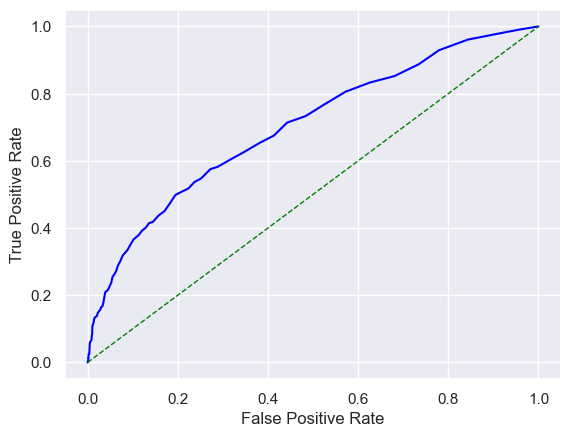

In [65]:
# Building confusion matrix based on the false and true positive values
confusion_matrix(test_y, predicted)
print('Confusion Matrix')
print(confusion_matrix(test_y, predicted))

# Making predictions on the training set
train_predictions = model.predict(train_x)

# Calculating and printing precision and recall values on the training set
print('Precision Value:', precision_score(train_y, train_predictions))
print('Recall value:', recall_score(train_y, train_predictions))

# Plotting the ROC curve
sns.set()

# Compute the false positive rate (fpr) and true positive rate (tpr)
fpr, tpr, _ = roc_curve(test_y, probabilities[:, 1])

# Plot the ROC curve
plt.plot(fpr, tpr, color='blue')
plt.plot([0, 1], [0, 1], color='green', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


In [66]:
def predict_delay(departure_date_time, origin, destination):
    try:
        # Parsing the input departure date and time
        departure_date_time_parsed = datetime.strptime(departure_date_time, '%d/%m/%Y %H:%M:%S')
    except ValueError as e:
        return 'Error parsing date/time - {}'.format(e)

    # Extracting relevant information from the parsed date and time
    month = departure_date_time_parsed.month
    day = departure_date_time_parsed.day
    day_of_week = departure_date_time_parsed.isoweekday()
    hour = departure_date_time_parsed.hour

    # Converting origin and destination to uppercase
    origin = origin.upper()
    destination = destination.upper()

    # Creating input data for the model prediction
    input_data = [{'MONTH': month,
                   'DAY_OF_MONTH': day,
                   'DAY_OF_WEEK': day_of_week,
                   'CRS_DEP_TIME': hour,
                   'ORIGIN_ATL': 1 if origin == 'ATL' else 0,
                   'ORIGIN_DTW': 1 if origin == 'DTW' else 0,
                   'ORIGIN_JFK': 1 if origin == 'JFK' else 0,
                   'ORIGIN_MSP': 1 if origin == 'MSP' else 0,
                   'ORIGIN_SEA': 1 if origin == 'SEA' else 0,
                   'DEST_ATL': 1 if destination == 'ATL' else 0,
                   'DEST_DTW': 1 if destination == 'DTW' else 0,
                   'DEST_JFK': 1 if destination == 'JFK' else 0,
                   'DEST_MSP': 1 if destination == 'MSP' else 0,
                   'DEST_SEA': 1 if destination == 'SEA' else 0 }]

    # Predicting the delay probability using the model
    return model.predict_proba(pd.DataFrame(input_data))[0][0]

# Example usage of the predict_delay function
print(predict_delay('16/11/2020 13:30:00', 'MSP', 'JFK'))


0.6


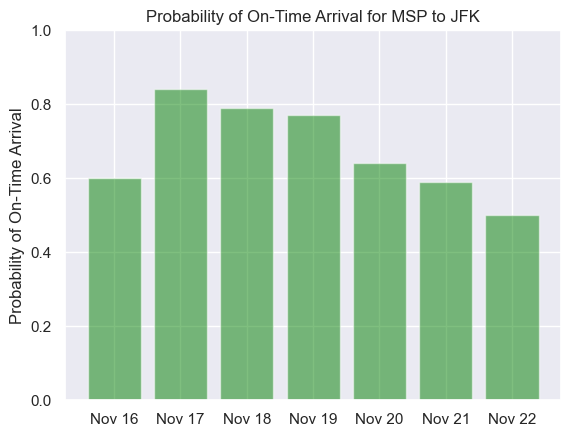

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# Labels for each day
labels = ('Nov 16', 'Nov 17', 'Nov 18', 'Nov 19', 'Nov 20', 'Nov 21', 'Nov 22')

# Values representing the probability of on-time arrival for each day
values = (
    predict_delay('16/11/2020 13:30:00', 'MSP', 'JFK'),
    predict_delay('17/11/2020 13:30:00', 'MSP', 'JFK'),
    predict_delay('18/11/2020 13:30:00', 'MSP', 'JFK'),
    predict_delay('19/11/2020 13:30:00', 'MSP', 'JFK'),
    predict_delay('20/11/2020 13:30:00', 'MSP', 'JFK'),
    predict_delay('21/11/2020 13:30:00', 'MSP', 'JFK'),
    predict_delay('22/11/2020 13:30:00', 'MSP', 'JFK')
)

# Array of indices for the labels
alabels = np.arange(len(labels))

# Plotting the histogram
plt.bar(alabels, values, align='center', alpha=0.5, color='green')
plt.xticks(alabels, labels)
plt.ylabel('Probability of On-Time Arrival')
plt.ylim((0.0, 1.0))
plt.title('Probability of On-Time Arrival for MSP to JFK')
plt.show()
